In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay

In [2]:
EXAM_NAMES = ['Kuis 2', 'UTS']
EXAM_NUMBERS = {
    'Kuis 2': ['IA', 'IB', 'IC'],
    'UTS': ['IA', 'IB']
}
EXAMS = []
for exam_name in EXAM_NAMES:
    for exam_number in EXAM_NUMBERS[exam_name]:
        EXAMS.append((exam_name, exam_number))

LB = {
    'All': 0.6562801963,
    'Kuis 2 IA': 0.1447276516,
    'Kuis 2 IB': 0.3178719202,
    'Kuis 2 IC': 0.6346878475,
    'UTS IA': 0.5107134316,
    'UTS IB': 0.4047760493
}

X_AXIS = 'nilai autograder'
Y_AXIS = 'nilai manual'
EPS = 0.001

import os 
import sys

module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path) 
    
from grader.src.ged.classes.general_cost_function import RelabelMethod
from grader.src.grader import Grader, GraphPreprocessType

REAL_GRADE_FILENAME = 'Real Results.csv' 
AFILE_PREFIX = 'Grade_'

real_dataframe = pd.read_csv(REAL_GRADE_FILENAME)
dataframes = {}
for node_cost in range(1, 4):
    for edge_cost in range(1, 4):
        if node_cost == edge_cost and node_cost != 1:
            continue
        for relabel_method in RelabelMethod.__iter__():
            for graph_preprocess_type in GraphPreprocessType.__iter__():
                for time_limit in [1000, 3000, 10000]:
                    filename = f'Time Data_{relabel_method.name}_{graph_preprocess_type.name}_{time_limit}_C{node_cost}{edge_cost}.csv'
                    if filename not in os.listdir('./'):
                        continue
                    dataframes[filename] = pd.read_csv(filename).rename(columns={'grade': 'nilai autograder'})
                    dataframes[filename] = pd.merge(dataframes[filename], real_dataframe, on=['nim', 'exam_name', 'number'])
                    
# for relabel_method in RelabelMethod.__iter__():
#     for graph_preprocess_type in GraphPreprocessType.__iter__():
#         for time_limit in [1000, 3000, 10000]:
#             filename = f'Time Data_{relabel_method.name}_{graph_preprocess_type.name}_{time_limit}.csv'
#             if filename not in os.listdir('./'):
#                 continue
#             dataframes[filename] = pd.read_csv(filename).rename(columns={'grade': 'nilai autograder'})
#             dataframes[filename] = pd.merge(dataframes[filename], real_dataframe, on=['nim', 'exam_name', 'number'])

SENDJAJA = 'Grade Results.csv'
dataframes[SENDJAJA] = pd.read_csv(SENDJAJA).rename(columns={'grade': 'nilai autograder'})
dataframes[SENDJAJA] = pd.merge(dataframes[SENDJAJA], real_dataframe, on=['nim', 'exam_name', 'number'])


# relabel_method = RelabelMethod.BOOLEAN_COUNT
# graph_preprocess_type = GraphPreprocessType.UNCOLLAPSE
# filename = f'Test Coef_{relabel_method.name}_{graph_preprocess_type.name}.csv'
# if filename in os.listdir('./'):
#     dataframes[filename] = pd.read_csv(filename).rename(columns={'grade': 'nilai autograder'})
#     dataframes[filename] = pd.merge(dataframes[filename], real_dataframe, on=['nim', 'exam_name', 'number'])

In [3]:
# Correlation function
def correlation(df):
    return df.corr()

In [4]:
# MAE (Mean Absolute Error) function
def mae(df):
    return mean_absolute_error(df[X_AXIS], df[Y_AXIS])

In [5]:
# Linear Regression Plot function
def linear_regression_plot(name, df):
    m, b = np.polyfit(df[X_AXIS], df[Y_AXIS], 1)
    print(f'Info for plot={name}: m={m}, b={b}')
    fig, ax = plt.subplots(figsize=(8, 8), dpi=60)
    ax.scatter(df[X_AXIS], df[Y_AXIS])
    ax.set_title(f'Perbandingan Hasil Penilaian Menggunakan Sistem Autograder\n dan Hasil Penilaian Manual oleh Pendidik\n{name}')
    ax.set_xlabel('Hasil Penilaian Menggunakan Sistem Autograder')
    ax.set_ylabel('Hasil Penilaian Manual oleh Pendidik')
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    ax.set_aspect(1)
    ax.plot(df[Y_AXIS], m * df[Y_AXIS] + b)
    plt.show()

In [6]:
# Confusion Matrix Plot function
def confusion_matrix_plot(name, df):
    bins = [10 * x - EPS for x in range(11)] + [100 + EPS]
    labels = range(11)

    cat_X = pd.cut(df[X_AXIS], bins=bins, labels=labels)
    cat_Y = pd.cut(df[Y_AXIS], bins=bins, labels=labels)
    categorized_grade = pd.concat([cat_X, cat_Y], axis=1)
    
    cm = confusion_matrix(categorized_grade[X_AXIS], categorized_grade[Y_AXIS], labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10, 8), dpi=60)
    ax.set_title(f'Confusion Matrix Perbandingan Hasil Penilaian Menggunakan Sistem Autograder\n dan Hasil Penilaian Manual oleh Pendidik\n{name}')
    disp.plot(ax=ax)
    disp.ax_.set(xlabel=X_AXIS, ylabel=Y_AXIS)
    plt.show()

In [7]:
# Histogram Difference Plot Function
def histogram_dif_plot(name, df):
    n, bins, patches = plt.hist(x=df, bins='auto', rwidth=0.75)
    plt.grid(axis='y', alpha=0.80)
    plt.title(f'Histogram Perbedaan Nilai Autograder dengan Nilai Manual\n{name}')
    plt.xlabel('Nilai Perbedaan = Nilai Autograder - Nilai Manual')
    plt.ylabel('Frekuensi')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.show()

In [8]:
# Print Correlations
all_correls = {}
correls = []
for name, df in dataframes.items():
    corr = correlation(df)
    correls.append((corr[X_AXIS][Y_AXIS], name))
    all_correls[name] = {}
    all_correls[name]['All'] = corr[X_AXIS][Y_AXIS]
    
correls.sort(key=lambda x: -x[0])
for corr, name in correls:
    print(f'{name}: {corr}')

Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv: 0.7310405400736244
Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv: 0.7300279154821812
Grade Results.csv: 0.6562801963372779


In [9]:
exam_correls = {}
for exam in EXAMS:
    exam_correls[exam] = []
    for _, name in correls:
        df = dataframes[name]
        corr = correlation(df.loc[(df['exam_name'] == exam[0]) & (df['number'] == exam[1])])
        exam_correls[exam].append((corr[X_AXIS][Y_AXIS], name))
        all_correls[name][f'{exam[0]} {exam[1]}'] = corr[X_AXIS][Y_AXIS]
    exam_correls[exam].sort(reverse=True)
    
for exam in EXAMS:
    for corr, name in exam_correls[exam][:10]:
        print(f'{exam} {name}:\n {corr}', '\n-----\n')
    print('\n\n\n')
# for _, name in correls[90: 120]:
#     df = dataframes[name]
#     for exam in EXAMS:
#         corr = correlation(df.loc[(df['exam_name'] == exam[0]) & (df['number'] == exam[1])])
#         print(f'{exam} {name}:\n {corr[X_AXIS][Y_AXIS]}', '\n-----\n')

('Kuis 2', 'IA') Grade Results.csv:
 0.14472765155427839 
-----

('Kuis 2', 'IA') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv:
 -0.01596207049922576 
-----

('Kuis 2', 'IA') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv:
 -0.016290792387209832 
-----





('Kuis 2', 'IB') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv:
 0.5504421835372558 
-----

('Kuis 2', 'IB') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv:
 0.5504421835372558 
-----

('Kuis 2', 'IB') Grade Results.csv:
 0.31787192021786037 
-----





('Kuis 2', 'IC') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv:
 0.6441833419438782 
-----

('Kuis 2', 'IC') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv:
 0.644047063280291 
-----

('Kuis 2', 'IC') Grade Results.csv:
 0.634687847477691 
-----





('UTS', 'IA') Grade Results.csv:
 0.5107134315754333 
-----

('UTS', 'IA') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv:
 0.40304420763435483 
-----

('UTS', 'IA') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv:
 0.37715572

In [10]:
count_top = {}
for exam in EXAMS:
    for corr, name in exam_correls[exam]:
        if corr >= LB[f'{exam[0]} {exam[1]}'] * 0.8:
            if name not in count_top:
                count_top[name] = 0
            count_top[name] += 1
    
top_name = [x for x in count_top.items()]
top_name.sort(reverse=True, key=lambda x: (x[1], all_correls[x[0]]['All']))
vis = {}
for name, count in top_name:
    if count not in vis:
        vis[count] = 0
    if vis[count] >= 3:
        continue
    print(f'{name}: {count}')
    for exam, corr in all_correls[name].items():
        print(f'{exam}: {corr}')
    print()
    vis[count] += 1

Grade Results.csv: 5
All: 0.6562801963372779
Kuis 2 IA: 0.14472765155427839
Kuis 2 IB: 0.31787192021786037
Kuis 2 IC: 0.634687847477691
UTS IA: 0.5107134315754333
UTS IB: 0.40477604933116773

Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv: 2
All: 0.7310405400736244
Kuis 2 IA: -0.016290792387209832
Kuis 2 IB: 0.5504421835372558
Kuis 2 IC: 0.644047063280291
UTS IA: 0.40304420763435483
UTS IB: 0.1202347613633051

Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv: 2
All: 0.7300279154821812
Kuis 2 IA: -0.01596207049922576
Kuis 2 IB: 0.5504421835372558
Kuis 2 IC: 0.6441833419438782
UTS IA: 0.377155721420282
UTS IB: 0.1202347613633051



In [11]:
# Print MAE
# for name, df in dataframes.items():
#     print(f'MAE (Mean Absolute Error) of dataframe {name} exam: {mae(df)}')
    
maes = []
for name, df in dataframes.items():
    maes.append((mae(df), name))
maes.sort()
for mae, name in maes:
    print(f'{name}: {mae}')

Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv: 10.748775108669827
Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv: 10.75711020601699
Grade Results.csv: 13.108726565217047


Linear Regression Plot of Grade Results.csv exam:
Info for plot=Grade Results.csv: m=0.6494050079710322, b=19.19245395383932


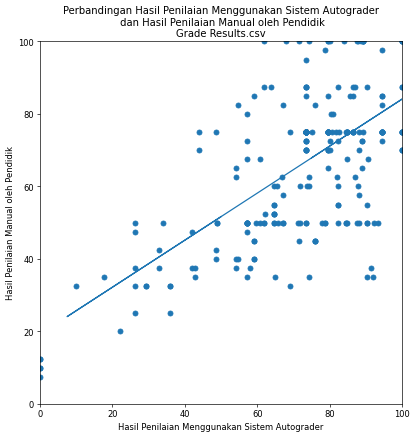

Linear Regression Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv exam:
Info for plot=Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv: m=0.8632390289862819, b=6.589523435201394


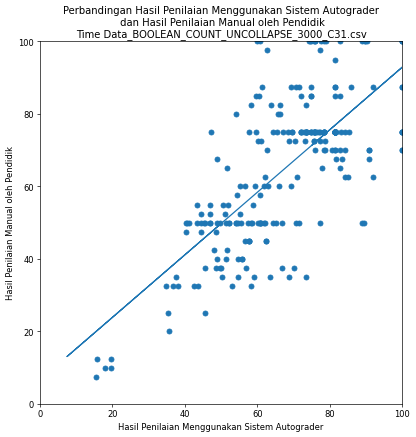

Linear Regression Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv exam:
Info for plot=Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv: m=0.8623464480168226, b=6.699188920893274


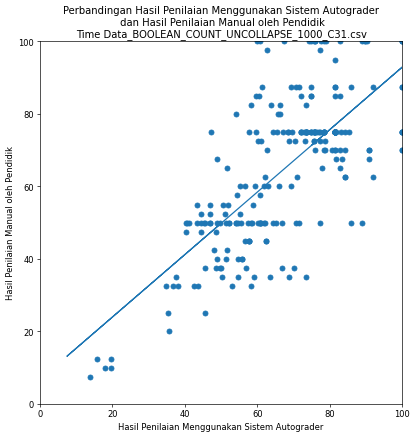

Linear Regression Plot of Grade Results.csv exam:
Info for plot=Grade Results.csv: m=0.6494050079710322, b=19.19245395383932


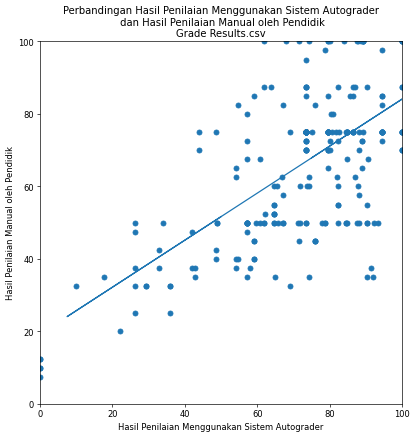

In [12]:
for _, name in [(all_correls[SENDJAJA]['All'], SENDJAJA)] + correls[:10]:
    df = dataframes[name]
    print(f'Linear Regression Plot of {name} exam:')
    linear_regression_plot(name, df)

Confusion Matrix Plot of Grade Results.csv exam:


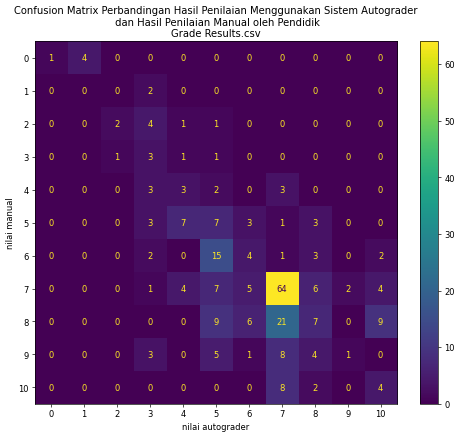

Confusion Matrix Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv exam:


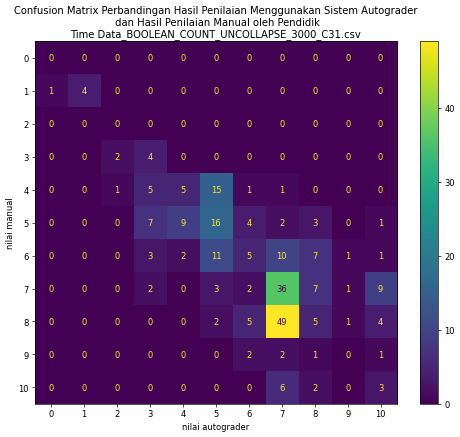

Confusion Matrix Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv exam:


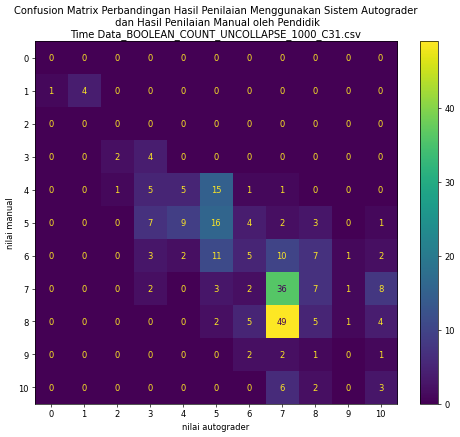

Confusion Matrix Plot of Grade Results.csv exam:


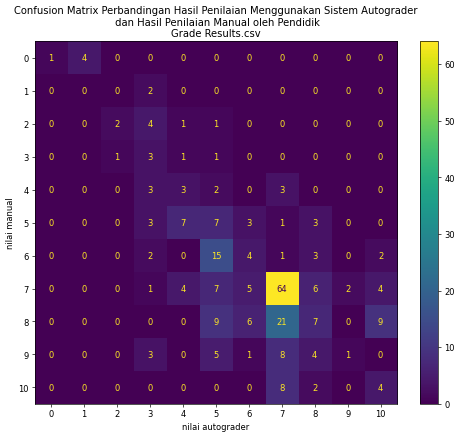

In [13]:
for _, name in [(all_correls[SENDJAJA]['All'], SENDJAJA)] + correls[:10]:
    df = dataframes[name]
    print(f'Confusion Matrix Plot of {name} exam:')
    confusion_matrix_plot(name, df)

Histogram Difference Plot of Grade Results.csv exam:
Data correlation: 0.6562801963372779, Average difference: 5.890472719041822


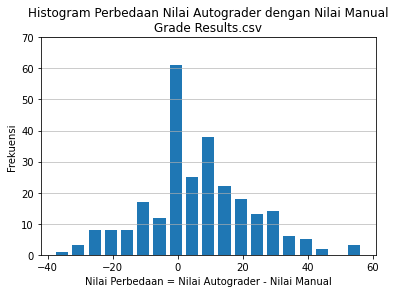

Histogram Difference Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv exam:
Data correlation: 0.7310405400736244, Average difference: 2.7678319239550966


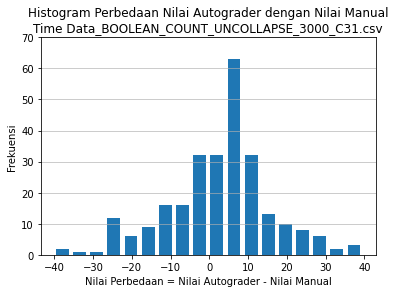

Histogram Difference Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv exam:
Data correlation: 0.7300279154821812, Average difference: 2.7114810360178856


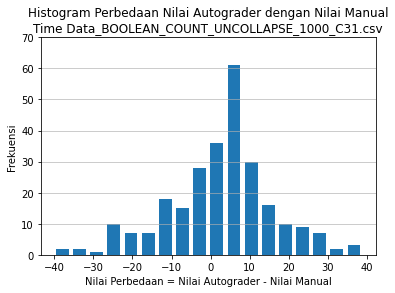

Histogram Difference Plot of Grade Results.csv exam:
Data correlation: 0.6562801963372779, Average difference: 5.890472719041822


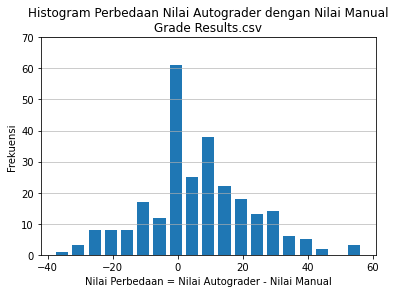

In [14]:
# Show Histogram Difference Plot
for corr, name in [(all_correls[SENDJAJA]['All'], SENDJAJA)] + correls[:10]:
    df = dataframes[name]
    print(f'Histogram Difference Plot of {name} exam:')
    print(f'Data correlation: {corr}, Average difference: {np.average(df[X_AXIS] - df[Y_AXIS])}')
    histogram_dif_plot(name, df[X_AXIS] - df[Y_AXIS])